pixelliste für einen nutzer holen

In [1]:
from src.data.dataset_functions import get_dataframe

dataFrame = get_dataframe(True) # sample data only
from src.features.feature_functions import group_dataframe_by_user
groupedFrame = group_dataframe_by_user(dataFrame)

headrow = groupedFrame.head()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/11 17:39:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pyspark.sql.functions as F

print(headrow)

Row(user_id='AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', count=20, collect_list(x)=[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], collect_list(y)=[5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], collect_list(t)=[184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961], collect_list(pixel_color)=['#FFA800', '#FF4500', '#B44AC0', '#E4ABFF', '#FFA800', '#3690EA', '#FFFFFF', '#BE0039', '#FF4500', '#2450A4', '#FFA800', '#FFFFFF', '#FFA800', '#9C6926', '#FFA800', '#000000', '#2450A4', '#FFA800', '#000000', '#E4ABFF'])


In [28]:
import matplotlib.pyplot as plt
import numpy as np

from src.models.models import RZModel




[[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], [5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], [184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961]]
red
red
not None!red
color is red


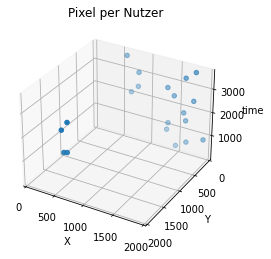

<Figure size 432x288 with 0 Axes>

In [27]:
from src.visualization.visuialization_functions import plot_pixel_boundingbox,plot_list_of_pixellist
pixelliste = [headrow['collect_list(x)'],headrow['collect_list(y)'],headrow['collect_list(t)']]
print(pixelliste)
fig1 = plt.figure()
ax = fig1.add_subplot(projection='3d')
plot_pixellist(pixellist=pixelliste,ax = ax, finish = False,color='red')
plot_list_of_pixellist(pixellistlist=[pixelliste],ax = ax, finish = True,color='red')
plt.savefig('bounding_boxes.png', dpi = 300)



[[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], [5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], [184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961]]
blue


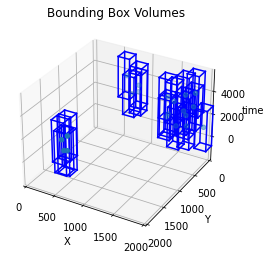

In [13]:
from src.visualization.visuialization_functions import *
import numpy as np
print(pixelliste)
RZModel.max_xy_dist = 100
RZModel.max_t_dist = 30*60
ax = None
ax = plot_pixellist(pixelliste,ax,False)
for i in np.arange(0,len(pixelliste[0])):
    plot_pixel_boundingbox(pixelliste[0][i],pixelliste[1][i],pixelliste[2][i],ax,False)
plt.savefig('bounding_boxes.png', dpi = 300)

<Figure size 432x288 with 0 Axes>